# Pre-Modeling
- Exploratory Data Analysis (EDA): missing values, unique counts, skewness, kurtosis, correlations
- Preprocessing: encoding target variable
- Feature Engineering: creating binned features for Utilization_Ratio, DTI_Ratio, Income and dropping raw columns
- Skewness Correction: transforming skewed numeric features using Yeo-Johnson
- Feature Processing: calculating Information Value (IV), handling invalid WoE, and selecting features based on IV threshold
- Train-test Split: stratified split of dataset
- Final data preparation: X_train, X_test, y_train, y_test ready for modeling

## Import functions from scripts

In [70]:
import sys
sys.path.append('../scripts')

from eda import run_eda_summary
from preprocessing import encode_target
from feature_engineering import create_binned_features, handle_skewness
from data_split import train_test_split_data
from feature_processing import analyze_features_iv, select_features_by_iv

import pandas as pd
import boto3

## Load data from S3

In [73]:
bucket_name = 'credit-scorecard-project'
file_key = 'data/training/raw_credit_data_training.csv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df = pd.read_csv(obj['Body'])

print(f"✅ Loaded data from S3: {df.shape}")
df.head()

✅ Loaded data from S3: (12000, 26)


Application_ID  FICO_Score  Num_Inquiries  Utilization_Ratio  \
0       A1013902         678              3               0.62   
1       A1003525         613              8               0.81   
2       A1016296         702              3               0.46   
3       A1009864         702              4               0.49   
4       A1010498         632              4               0.74   

   Num_Tradelines  Months_Oldest_Trade  Derogs_30DPD  Derogs_60DPD  \
0              11                   37             0             0   
1               7                   23             1             0   
2              12                   58             0             0   
3               7                   24             0             0   
4               5                   24             2             1   

   Derogs_90DPD  Income  ...  Loan_Term  Is_Existing_Customer  \
0             0   76827  ...         60                     0   
1             0   36089  ...         12                     0   
2             0   63924  ...         60                     0   
3             0   79881  ...         48                     0   
4             0   33346  ...         48                     1   

  Relationship_Tenure  Avg_Deposit_Balance Prev_Bank_Delinquency  \
0                   0              0.00000                     0   
1                   0              0.00000                     0   
2                   0              0.00000                     0   
3                   0              0.00000                     0   
4                  21          18690.90243                     0   

   Unemployment_Rate  Interest_Rate  Consumer_Confidence  Derog_Any  \
0                5.0            2.0                  100          0   
1                5.0            2.0                  100          1   
2                4.5            2.5                   98          0   
3                4.7            2.0                  100          0   
4                5.0            2.0                  100          1   

   Default_Flag  
0           Yes  
1           Yes  
2           Yes  
3           Yes  
4           Yes  

[5 rows x 26 columns]

## Run EDA summary

✅ Data shape: (12000, 26)

🔍 Missing values per column:
Application_ID           0
FICO_Score               0
Num_Inquiries            0
Utilization_Ratio        0
Num_Tradelines           0
Months_Oldest_Trade      0
Derogs_30DPD             0
Derogs_60DPD             0
Derogs_90DPD             0
Income                   0
DTI_Ratio                0
Age                      0
Residence_Type           0
Residence_Tenure         0
Loan_Purpose             0
Loan_Amount              0
Loan_Term                0
Is_Existing_Customer     0
Relationship_Tenure      0
Avg_Deposit_Balance      0
Prev_Bank_Delinquency    0
Unemployment_Rate        0
Interest_Rate            0
Consumer_Confidence      0
Derog_Any                0
Default_Flag             0
dtype: int64

🔍 Unique counts per column:
Application_ID           12000
FICO_Score                 271
Num_Inquiries                9
Utilization_Ratio           91
Num_Tradelines              20
Months_Oldest_Trade        295
Derogs_30DPD  

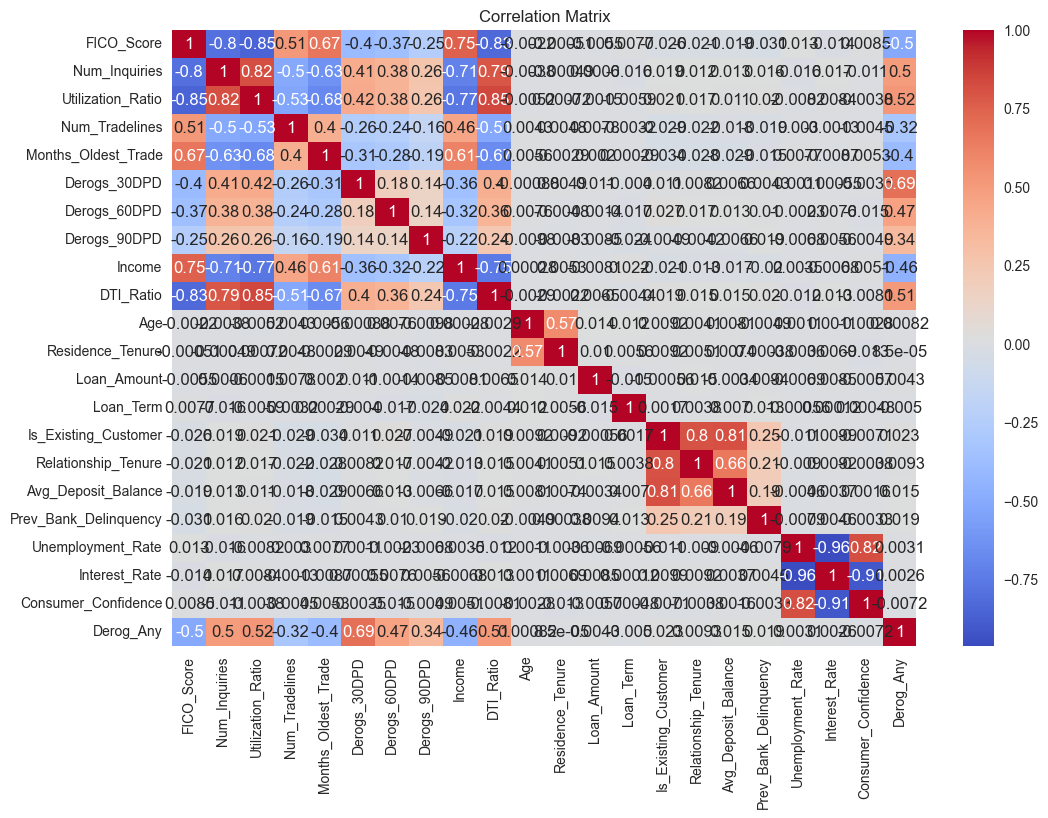

In [75]:
corr_matrix = run_eda_summary(df)

## Encode Target

In [77]:
df_encoded = encode_target(df)
print("✅ Encoded target variable. Value counts:")
print(df_encoded['Default_Flag'].value_counts())

✅ Encoded target variable. Value counts:
Default_Flag
0    11137
1      863
Name: count, dtype: int64


## Create binned features (and drop raw columns)
python
Copy
Edit


In [79]:
# Automatically uses defaults: 'Utilization_Ratio', 'DTI_Ratio', 'Income'
df_engineered = create_binned_features(df_encoded)

print("✅ Binned features created and raw columns dropped.")
print("Columns now available:", df_engineered.columns.tolist())


✅ Binned features created and raw columns dropped.
Columns now available: ['Application_ID', 'FICO_Score', 'Num_Inquiries', 'Num_Tradelines', 'Months_Oldest_Trade', 'Derogs_30DPD', 'Derogs_60DPD', 'Derogs_90DPD', 'Age', 'Residence_Type', 'Residence_Tenure', 'Loan_Purpose', 'Loan_Amount', 'Loan_Term', 'Is_Existing_Customer', 'Relationship_Tenure', 'Avg_Deposit_Balance', 'Prev_Bank_Delinquency', 'Unemployment_Rate', 'Interest_Rate', 'Consumer_Confidence', 'Derog_Any', 'Default_Flag', 'Utilization_Ratio_Bin', 'DTI_Ratio_Bin', 'Income_Bin']


## Handle skewness (on other numeric columns)

In [81]:
# Now uses default exclusions inside function
df_skew_fixed = handle_skewness(df_engineered)

print("✅ Skewness handled for remaining numeric features.")

Transforming Derogs_30DPD (skew=2.14)
Transforming Derogs_60DPD (skew=3.19)
Transforming Derogs_90DPD (skew=4.20)
Transforming Relationship_Tenure (skew=1.23)
Transforming Avg_Deposit_Balance (skew=1.22)
Transforming Prev_Bank_Delinquency (skew=4.69)
✅ Skewness handled for remaining numeric features.


## Train-test split

In [83]:
train_df, test_df = train_test_split_data(df_skew_fixed)

print(f"✅ Train shape: {train_df.shape}")
print(f"✅ Test shape: {test_df.shape}")


✅ Train shape: (9600, 26)
✅ Test shape: (2400, 26)


## Analyze IV

In [85]:
features = [col for col in train_df.columns if col not in ['Application_ID', 'Default_Flag']]
iv_results = analyze_features_iv(train_df, features)

print(iv_results)

                  Feature        IV
0              FICO_Score  0.538213
22          DTI_Ratio_Bin  0.509667
1           Num_Inquiries  0.502843
21  Utilization_Ratio_Bin  0.502263
23             Income_Bin  0.463127
3     Months_Oldest_Trade  0.415566
2          Num_Tradelines  0.201206
4            Derogs_30DPD  0.090946
5            Derogs_60DPD  0.046169
9        Residence_Tenure  0.015095
11            Loan_Amount  0.014571
15    Avg_Deposit_Balance  0.007601
17      Unemployment_Rate  0.007389
10           Loan_Purpose  0.006714
7                     Age  0.006382
14    Relationship_Tenure  0.006359
19    Consumer_Confidence  0.004893
18          Interest_Rate  0.003316
12              Loan_Term  0.003295
8          Residence_Type  0.000902
16  Prev_Bank_Delinquency  0.000000
6            Derogs_90DPD  0.000000
20              Derog_Any  0.000000
13   Is_Existing_Customer  0.000000


## Select features by IV

In [88]:
selected_features = select_features_by_iv(iv_results, threshold=0.02)

print(f"✅ Selected features (IV >= 0.02): {selected_features}")

✅ Selected features (IV >= 0.02): ['FICO_Score', 'DTI_Ratio_Bin', 'Num_Inquiries', 'Utilization_Ratio_Bin', 'Income_Bin', 'Months_Oldest_Trade', 'Num_Tradelines', 'Derogs_30DPD', 'Derogs_60DPD']


## SAVE SELECTED FEATURES FOR DEPLOYMENT

In [90]:
# Save selected features to known absolute path
import json

full_path = r"C:\Users\brook\credit-decisioning-mlops\deployment\model\selected_features.json"

with open(full_path, "w") as f:
    json.dump(selected_features, f, indent=4)

print(f"✅ Saved selected feature list ({len(selected_features)} features) to:\n{full_path}")


✅ Saved selected feature list (9 features) to:
C:\Users\brook\credit-decisioning-mlops\deployment\model\selected_features.json


## Final data for modeling

In [92]:
X_train = train_df[selected_features]
y_train = train_df['Default_Flag']

X_test = test_df[selected_features]
y_test = test_df['Default_Flag']

print(f"✅ Ready for modeling. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

✅ Ready for modeling. X_train shape: (9600, 9), X_test shape: (2400, 9)


# Modeling

## PyCaret Imports & Setup

In [95]:
from pycaret.classification import *

# Combine features and target
df_model = pd.concat([X_train, y_train], axis=1)

# Updated PyCaret setup (v3+)
clf_setup = setup(
    data=df_model,
    target='Default_Flag',
    session_id=42,
    fold=5,
    verbose=True  # Replace 'silent=False'
)


## Compare models

In [105]:
best_model = compare_models(n_select=3, sort='AUC')

In [107]:
print(best_model[0])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


## Tune the best model

In [110]:
tuned_model = tune_model(best_model[0], optimize='AUC')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [111]:
print(tuned_model)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.2, fit_intercept=True,
              l1_ratio=0.9100000001, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


In [112]:
tuned_model.get_params()

{'alpha': 0.01,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.2,
 'fit_intercept': True,
 'l1_ratio': 0.9100000001,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Evaluate performance

### Might need to know the exact model that is selected in order to get the plots that work best for the specific model

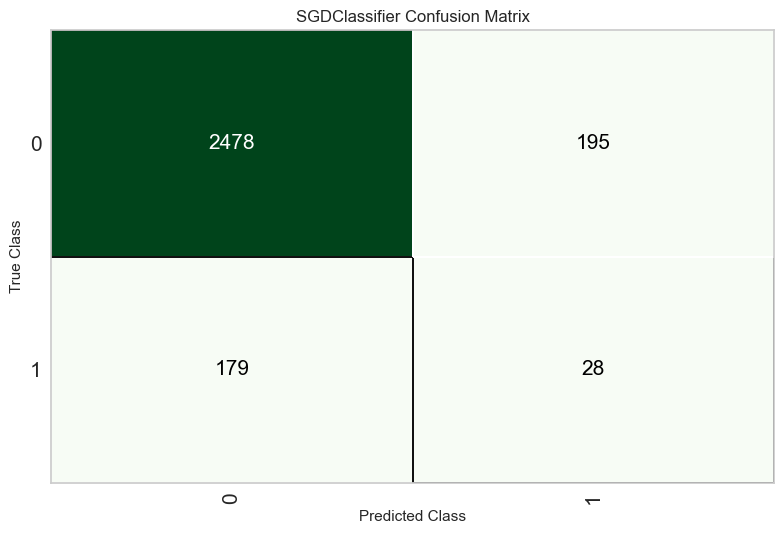

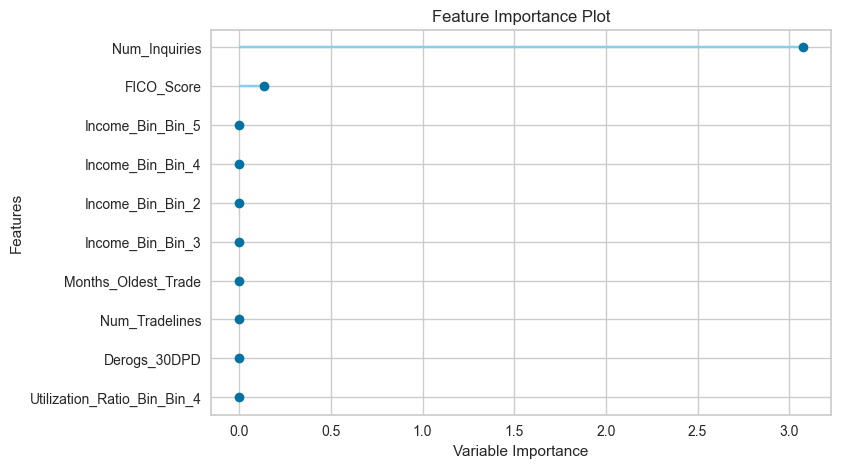

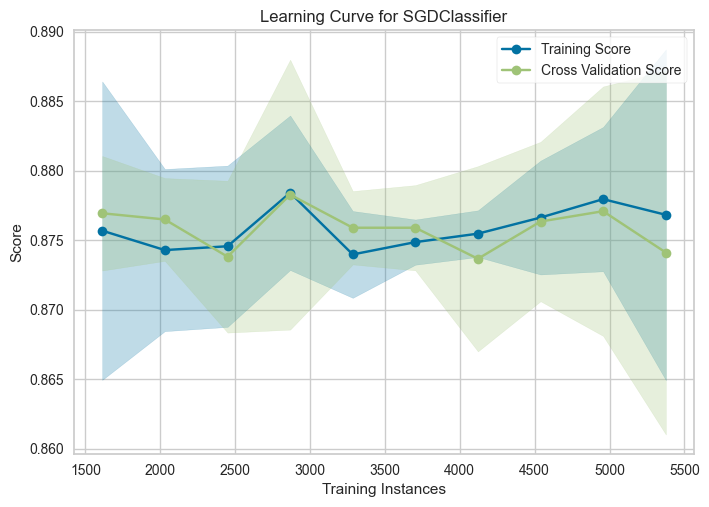

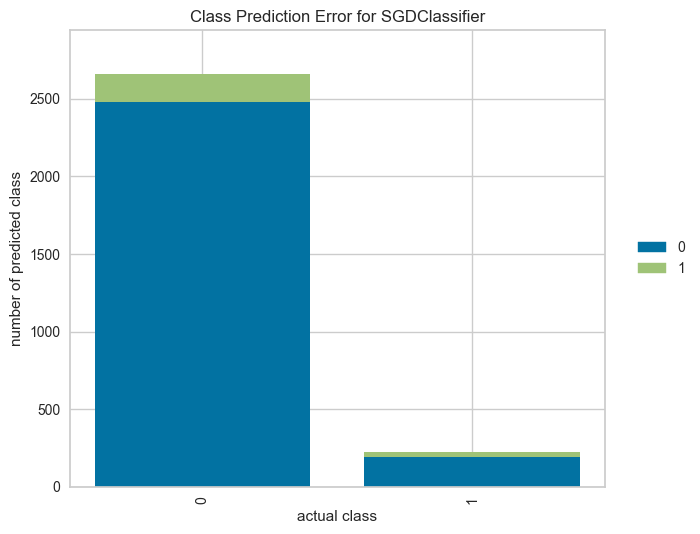

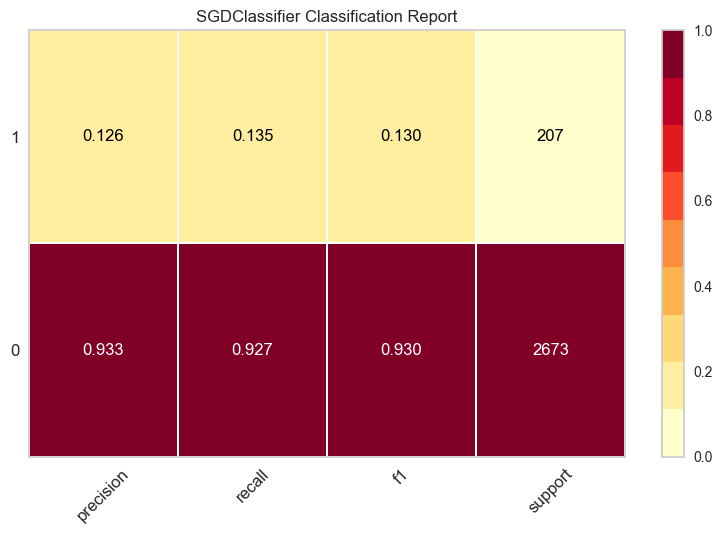

In [115]:
# Plots that run for all models

plot_model(tuned_model, plot='confusion_matrix')
plot_model(tuned_model, plot='feature')
plot_model(tuned_model, plot='learning')
plot_model(tuned_model, plot='error')
plot_model(tuned_model, plot='class_report')


## Finalize and test on holdout set

In [117]:
final_model = finalize_model(tuned_model)

## Predict on test set

In [119]:
df_test_results = predict_model(final_model, data=X_test)

In [120]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Get predicted labels from PyCaret
y_pred = df_test_results['prediction_label']
y_true = y_test.reset_index(drop=True)  # Match indexing

# Step 2: Print classification report
print("🔍 Classification Report on Test Set:")
print(classification_report(y_true, y_pred))

# Step 3: Confusion matrix
print("🧮 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


🔍 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2227
           1       0.15      0.21      0.18       173

    accuracy                           0.86      2400
   macro avg       0.55      0.56      0.55      2400
weighted avg       0.88      0.86      0.87      2400

🧮 Confusion Matrix:
[[2024  203]
 [ 136   37]]


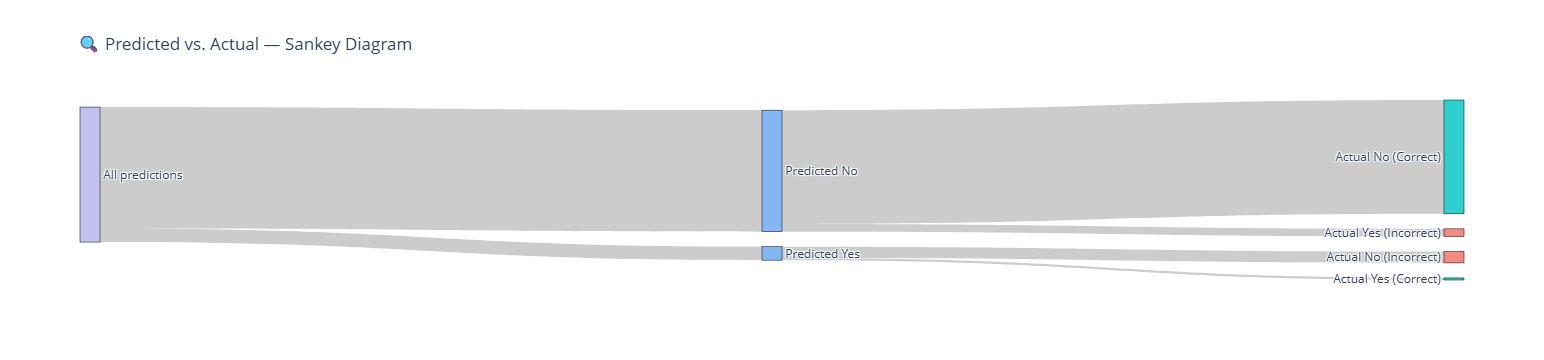

In [121]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Build inputs
y_true = y_test.reset_index(drop=True)
y_pred = df_test_results['prediction_label'].reset_index(drop=True)

# Create a DataFrame with true and predicted
df_eval = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

# Label mapping for Sankey
label_list = ['All predictions', 'Predicted No', 'Predicted Yes',
              'Actual No (Correct)', 'Actual Yes (Correct)',
              'Actual No (Incorrect)', 'Actual Yes (Incorrect)']

# Mapping of flows: source -> target with counts
source = []
target = []
value  = []

# From all → predicted classes
for pred in [0, 1]:
    count = df_eval[df_eval['Predicted'] == pred].shape[0]
    source.append(0)               # All predictions
    target.append(pred + 1)        # Predicted No (1) or Yes (2)
    value.append(count)

# From predicted → actual (Correct/Incorrect)
for pred in [0, 1]:
    for actual in [0, 1]:
        count = df_eval[(df_eval['Predicted'] == pred) & (df_eval['Actual'] == actual)].shape[0]
        source.append(pred + 1)
        if pred == actual:
            target.append(3 if actual == 0 else 4)  # Correct
        else:
            target.append(5 if actual == 0 else 6)  # Incorrect
        value.append(count)

# Step 2: Plot Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=label_list,
        color=["#c2c2f0", "#84b6f4", "#84b6f4", "#30cfcf", "#30cfcf", "#f28b82", "#f28b82"]
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="🔍 Predicted vs. Actual — Sankey Diagram", font_size=12)
fig.show()


# SAVE MODEL FILE

In [123]:
from pycaret.classification import save_model
import os

# Full absolute path to the intended model save location
full_model_path = r"C:\Users\brook\credit-decisioning-mlops\deployment\model\credit_champion_model"

# Ensure parent folders exist (optional if folder is already there)
os.makedirs(os.path.dirname(full_model_path), exist_ok=True)

# Save model using absolute path (PyCaret will add .pkl)
save_model(final_model, full_model_path)

print(f"✅ Model saved to: {full_model_path}.pkl")


Transformation Pipeline and Model Successfully Saved
✅ Model saved to: C:\Users\brook\credit-decisioning-mlops\deployment\model\credit_champion_model.pkl
